In [1]:
import torch
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
import itertools
import pdb
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import sys

sys.path.insert(0, './src')

from data import Dataset
from kernels import HMC_our, HMC_vanilla
from models import Gen_network, Inf_network
from target import NN_bernoulli
from utils import plot_digit_samples, get_samples
from args import get_args
import pyro
from pyro.distributions.transforms import AffineAutoregressive
from pyro.nn import AutoRegressiveNN

In [2]:
args = get_args()

In [3]:
dataset = Dataset(args, device=args.device)

In [4]:
encoder = Inf_network(args).to(args.device)
target = NN_bernoulli(kwargs=args, model=Gen_network(args.z_dim, args), device=args.device).to(args.device)
HMC = HMC_vanilla(args)
# IAF = nn.ModuleList([AffineAutoregressive(AutoRegressiveNN(args['z_dim'], [384])).to(device) for _ in range(K)])

In [5]:
params = [encoder.parameters()] #, IAF.parameters()]
optimizer_phi = torch.optim.Adam(params=itertools.chain(*params))
optimizer_theta = torch.optim.Adam(params=target.parameters())

In [6]:
mask_distr = torch.distributions.Uniform(torch.tensor(0.0, device=args.device),
                                                      torch.tensor(1.0, device=args.device))

In [7]:
random_code = args.std_normal.sample((64, args.z_dim))

  0%|          | 0/1000 [00:00<?, ?it/s]

obj_1: -205.44683837890625
obj_2: -292.7746276855469
Saved samples to ./pics/mnist_epoch_None_K_3_N_1_amortize_True.png


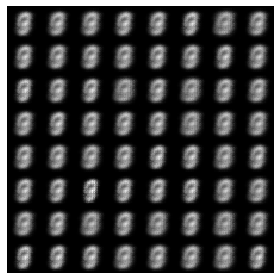

  0%|          | 1/1000 [01:02<17:13:50, 62.09s/it]

obj_1: -164.57261657714844
obj_2: -242.52655029296875
Saved samples to ./pics/mnist_epoch_None_K_3_N_1_amortize_True.png


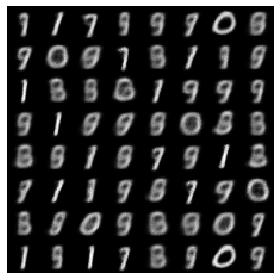

  0%|          | 2/1000 [02:04<17:12:16, 62.06s/it]

obj_1: -133.4352569580078
obj_2: -204.50648498535156
Saved samples to ./pics/mnist_epoch_None_K_3_N_1_amortize_True.png


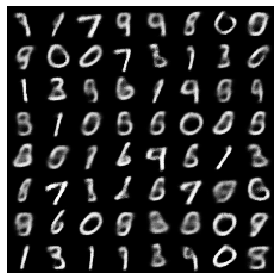

  0%|          | 3/1000 [03:06<17:11:05, 62.05s/it]

obj_1: -129.77017211914062
obj_2: -197.68365478515625
Saved samples to ./pics/mnist_epoch_None_K_3_N_1_amortize_True.png


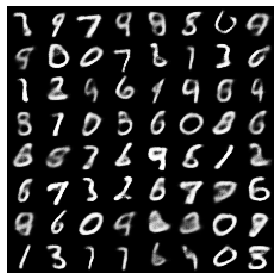

  0%|          | 4/1000 [04:08<17:09:50, 62.04s/it]

obj_1: -112.45097351074219
obj_2: -178.93820190429688
Saved samples to ./pics/mnist_epoch_None_K_3_N_1_amortize_True.png


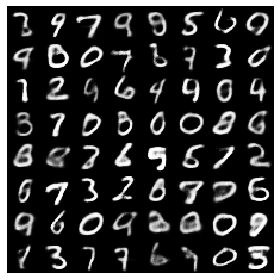

  0%|          | 5/1000 [05:10<17:10:30, 62.14s/it]

obj_1: -107.0126724243164
obj_2: -172.22955322265625
Saved samples to ./pics/mnist_epoch_None_K_3_N_1_amortize_True.png


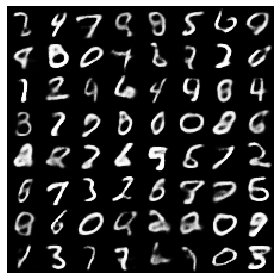

  1%|          | 6/1000 [06:12<17:10:53, 62.23s/it]

obj_1: -114.20664978027344
obj_2: -176.95855712890625
Saved samples to ./pics/mnist_epoch_None_K_3_N_1_amortize_True.png


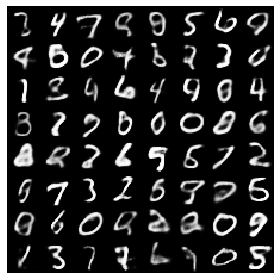

  1%|          | 7/1000 [07:15<17:10:55, 62.29s/it]

obj_1: -100.33476257324219
obj_2: -165.46534729003906
Saved samples to ./pics/mnist_epoch_None_K_3_N_1_amortize_True.png


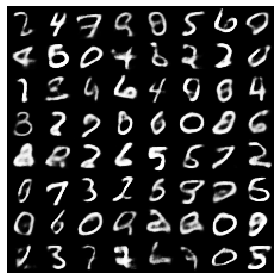

  1%|          | 8/1000 [08:17<17:10:38, 62.34s/it]

obj_1: -102.965087890625
obj_2: -167.1632843017578
Saved samples to ./pics/mnist_epoch_None_K_3_N_1_amortize_True.png


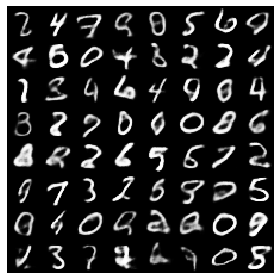

  1%|          | 9/1000 [09:20<17:10:03, 62.36s/it]

obj_1: -101.83949279785156
obj_2: -165.14341735839844
Saved samples to ./pics/mnist_epoch_None_K_3_N_1_amortize_True.png


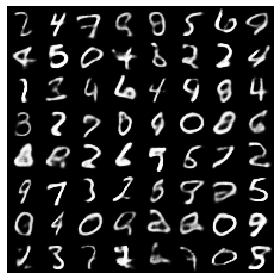

  1%|          | 10/1000 [10:22<17:09:22, 62.39s/it]

obj_1: -106.66752624511719
obj_2: -169.70413208007812
Saved samples to ./pics/mnist_epoch_None_K_3_N_1_amortize_True.png


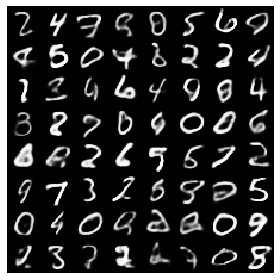

  1%|          | 11/1000 [11:25<17:08:43, 62.41s/it]

obj_1: -105.12149810791016
obj_2: -169.32290649414062
Saved samples to ./pics/mnist_epoch_None_K_3_N_1_amortize_True.png


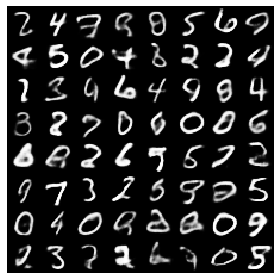

  1%|          | 12/1000 [12:27<17:07:47, 62.42s/it]

obj_1: -102.06166076660156
obj_2: -165.20657348632812
Saved samples to ./pics/mnist_epoch_None_K_3_N_1_amortize_True.png


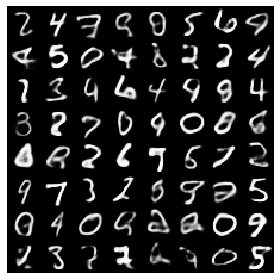

  1%|▏         | 13/1000 [13:30<17:06:53, 62.43s/it]

KeyboardInterrupt: 

In [8]:
print_info = 1
for ep in tqdm(range(args.num_epoches)):
    for b_num, batch_train in enumerate(dataset.next_train_batch()): # cycle over batches
#         pdb.set_trace()
        mu, sigma = encoder(batch_train)
        u = args.std_normal.sample(mu.shape)
        z = mu + sigma * u # reparametrization trick
        z_hmc = z.detach()
        sum_log_sigma = torch.sum(torch.log(sigma), 1)
        ###### objective for phi
        ####
        log_p = target.get_logdensity(z=z, x=batch_train)
        log_q = args.std_normal.log_prob(u).sum(1) - sum_log_sigma
        obj_1 = torch.mean(log_p - log_q)
        (-obj_1).backward()
        optimizer_phi.step()
        optimizer_phi.zero_grad()
        optimizer_theta.zero_grad()
        ###### objective for theta
        ####
        p_hmc = args.std_normal.sample(mu.shape)
        
        for k in range(args.K):
            z_hmc, p_hmc, _, _, _, _ = HMC.make_transition(q_old=z_hmc, p_old=p_hmc, target_distr=target, x=batch_train)
        obj_2 = torch.mean(target.get_logdensity(z=z_hmc, x=batch_train))
        (-obj_2).backward()
        optimizer_theta.step()
        optimizer_theta.zero_grad()
    if ep % print_info == 0:
        print('obj_1:', obj_1.cpu().detach().item())
        print('obj_2:', obj_2.cpu().detach().item())
        with torch.no_grad():
            plot_digit_samples(get_samples(target.decoder, random_code), args)

In [ ]:
num_samples = 10000

z_0 = torch.distributions.Normal(
        loc=torch.zeros(args.z_dim, dtype=torchType, device=device),
        scale=torch.ones(args.z_dim, dtype=torchType, device=device)).sample([num_samples]).requires_grad_(True)

g_samples = decoder(z_0)[0].view(num_samples, -1)

In [ ]:
def get_jacobian(x, z):
    jacobian = torch.empty(x.shape[1], z.shape[1], device=device, dtype=torchType)
    for dim in range(x.shape[1]):
        jacobian[dim, :] = torch.mean(torch.autograd.grad(x[:, dim].sum(), z, retain_graph=True)[0], dim=0)
    return jacobian

In [ ]:
mean_jac = get_jacobian(g_samples, z_0)

In [ ]:
mean_jac.shape

In [ ]:
u, s ,v = torch.svd(mean_jac)

In [ ]:
plt.plot(s.cpu().detach().numpy())
plt.yscale('log')
plt.title('Singular values decay')
plt.xlabel('Dimension number')
plt.ylabel('Singular value');